In [1]:
import sys
print(sys.version)
# should be 3.6

3.6.8 (default, May  7 2019, 14:58:50) 
[GCC 5.4.0 20160609]


In [2]:
from datetime import datetime
start_time = datetime.now()
print('start_time:', start_time)

start_time: 2019-11-13 17:40:00.226434


# pbi.ai templates
## Return of Experience

Welcome!

We created this notebook to provide a practical example of how AI and Data Science can be used when dealing with content personalization. It's also a follow up on our article Return of Experience which can be found at http://bit.ly/2qHwBBN 

**Our vision is that Artificial Intelligence isn't just about the code. Also, it's not just about fancy "business talk".**
That's why we combine theory with practical examples wherever it's possible. Our aim is to share knowledge with fellow AI experts, data scientists, machine learning engineers, marketing professionals and business analysts. In other words, all the people who are dealing with the data every day. Don't reinvent the wheel!

Have you been wondering how AI can help improve business? Our articles and tips could help you on your journey :) Visit our blog:
- http://bit.ly/pbiai-blog

Do you have an idea for a new AI product? Have you been thinking about using AI in your company? We can help you with that. You can reach us via our website
- https://www.pbi.ai/

or via social media

- facebook ( https://www.facebook.com/pbiai/ )
- LinkedIn ( https://www.linkedin.com/company/18178189/
- Twitter ( https://twitter.com/pbi_ai ).

Are you from the Czech Republic? Šablona je dostupná také v českém jazyce na http://bit.ly/AI_template_personalization_CZ

Enjoy!


## Template Content
### 1 Data
#### 1.1 Data exploration: the amount of data in general
#### 1.2 Data exploration: distribution over time
#### 1.3 Data exploration: customer segments
#### 1.4 Data exploration: item segments
### 2 Experiments and AI prototyping
#### 2.1 Hard coded rules
#### 2.2 Machine Learning
#### 2.3 Experiments and AI prototyping wrap-up

## 1 Data

**AI is only as good as the training data.** The result depends on how well the data covers key drivers of the problem we are trying to solve (read more on this topic in our article Unlocking AI potential in e-commerce and online business – the right data; https://www.pbi.ai/blog/2019/08/28/unlocking-ai-potential-in-e-commerce-the-right-data/ ).

In our examples, we will use a dummy dataset similar to a real e-commerce dataset. You can think of it as a log of purchases.

In [3]:
import pandas as pd # basic library for data manipulation

purchases = pd.read_csv("dummy_data_purchases.csv", sep=',') # load purchases
customers = pd.read_csv("dummy_data_customers.csv", sep=',') # load customers
items = pd.read_csv("dummy_data_items.csv", sep=',') # load items

purchases['timestamp'] = purchases['timestamp'].apply(
    lambda timestamp_string: datetime.strptime(timestamp_string, '%Y-%m-%d %H:%M:%S.%f') # parse the timestamp into the datetime object
)

First five rows of our **purchases dataset**:

In [4]:
purchases[:5]

customerid  itemid                  timestamp     price
0       11779   45481 2018-02-17 11:09:09.629588  12783.20
1       15492   45481 2019-02-20 02:01:51.322820  12648.64
2       11480   45481 2018-04-12 07:01:25.615314  13456.00
3       10002   45481 2018-05-09 10:01:18.987823  12244.96
4       16456   45481 2019-02-07 19:01:58.634323  13186.88

First five rows of our **customers dataset**:

In [5]:
customers[:5]

customerid  locationid  agegroupid  sexid
0       10000           7           0      0
1       10001           9           4      1
2       10002           2           2      0
3       10003           5           0      0
4       10004           5           0      0

First five rows of our **items dataset**:

In [6]:
items[:5]

itemid  categoryid  colorid  price_default
0       6           0        6          10140
1   32775           3        1          16845
2       8           5        3           6904
3   32777           2        6          18930
4   32779           2        0           3557

In [7]:
# merge customer and item features with purchases
purchases = pd.merge(purchases, customers, on='customerid')
purchases = pd.merge(purchases, items, on='itemid')

First five rows of our **purchases dataset after merging item features and customer features**:

In [8]:
purchases[:5]

customerid  itemid                  timestamp     price  locationid  \
0       11779   45481 2018-02-17 11:09:09.629588  12783.20          12   
1       15492   45481 2019-02-20 02:01:51.322820  12648.64          13   
2       11480   45481 2018-04-12 07:01:25.615314  13456.00          14   
3       10002   45481 2018-05-09 10:01:18.987823  12244.96           2   
4       16456   45481 2019-02-07 19:01:58.634323  13186.88          12   

   agegroupid  sexid  categoryid  colorid  price_default  
0           0      0           3        4          13456  
1           3      0           3        4          13456  
2           3      0           3        4          13456  
3           2      0           3        4          13456  
4           0      1           3        4          13456

Now, each row contains the following columns:

`customerid`: unique identifier of a customer

`itemid`: unique identifier of an item

`timestamp`: date and time of the purchase

`price`: item price during the purchase (including discounts)

`locationid`: unique identifier of a customer location

`agegroupid`: unique identifier of a customer age group

`sexid`: unique identifier of a customer sex

`categoryid`: unique identifier of an item category

`colorid`: unique identifier of an item color

`price_default`: default item price (before discounts)

Basically, **creating of a content personalization tool is the process of capturing relationships between items and customers**. That's why we need to check the distribution of our data first to determine if sufficient information is available.

**Important things to look for:**
    - the amount of data in general
    - distribution over time; date-time related anomalies (e.g. Christmas sales)
    - customer segments
    - item segments

Initial analysis helps us decide what AI method might be the best fit for our case. Let's explore the data!

### 1.1 Data exploration: the amount of data in general

In [9]:
from collections import Counter # function for quick computation of 

print('rows:', purchases.shape[0])
for column_name in ['customerid', 'itemid', 'categoryid', 'colorid']:
    print('%ss: %d' % (
        column_name,
        len(set(purchases[column_name]))
    ))

print('\nNumber of nrows containing a null or missing value:', Counter(pd.isnull(purchases).any(axis=1))[True])
    
print('\nmin date:', min(purchases['timestamp']))
print('max date:', max(purchases['timestamp']))

print('\nmin price:', min(purchases['price']))
print('max price:', max(purchases['price']))

rows: 66658
customerids: 9990
itemids: 10337
categoryids: 6
colorids: 9

Number of nrows containing a null or missing value: 0

min date: 2018-02-13 00:18:49.821487
max date: 2019-04-23 22:01:21.205666

min price: 1.6
max price: 24996.0


Our brief analysis revealed that we are dealing with **66k purchases across ~10k customers during a ~14-month period which is approximately one purchase per two months per customer**. The amount of data looks sufficient at first sight, and we will get a more precise picture once we analyze the data distribution.

We should mention that **there are no null or missing values**. This is good. If the opposite was true, we would need to find out what exactly happened in those cases. It is very important to know what data should be filtered out or replaced before mathematical modeling.

### 1.2 Data exploration: distribution over time

Another important thing to look at is the data distribution over time. The main reason is to **detect anomalies related to specific periods of the time**. Using data from these periods could damage our model because we want it to reflect the most common conditions.

Based on this analysis we can also determine whether we should build more models for some specific periods (e.g. workweek and weekend).

In [10]:
import numpy as np # library for the basic mathematical functions
import matplotlib # library for plotting
import matplotlib.pyplot as plt
import seaborn as sns # library for plotting

%matplotlib inline

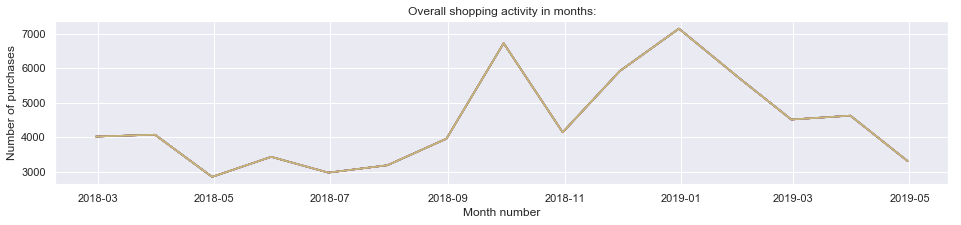

In [11]:
pd.plotting.register_matplotlib_converters() # timeseries converter

sns.set(rc={'figure.figsize':(16, 3)})
plt.figure()
plt.title('Overall shopping activity in months:')
plt.plot(purchases.set_index('timestamp').resample('M').count())
plt.xlabel('Month number')
plt.ylabel('Number of purchases')
plt.show()

The purchases distribution over time is extremely volatile. This could mean that there were big changes in the marketing strategy, big sales or other unusual time-related events. It could also mean that there was a software bug or an ETL-related problem (ETL = data Extraction-Transformation-Loading). **An important part of an AI development is perfect data understanding. We need to know what data should be filtered out**. In this particular case, we would ask the people who are responsible for creating this data set to clarify the meaning of spikes and dips in the number of purchases. For instance, what happened between March and August 2018?

### 1.3 Data exploration: customer segments

If we want to capture relationships between items, we need a proper number of customers who have bought at least two different items. This information tells us which items are probably related. If our customers are mostly one-time buyers, we will have a tough time. In such case, we will depend on the availability of customer-related features (e.g. gender and location) which could help us compute a similarity between customers and thus possible relevance between their purchases. **People data could be very tricky and if we underestimate the data preparation, we are at risk of developing a useless tool** (read more on this topic in our article Unlocking AI potential in e-commerce and online business – ethics; https://www.pbi.ai/blog/2019/09/17/unlocking-ai-potential-in-e-commerce-ethics/ ).

One-time Buyers:  92


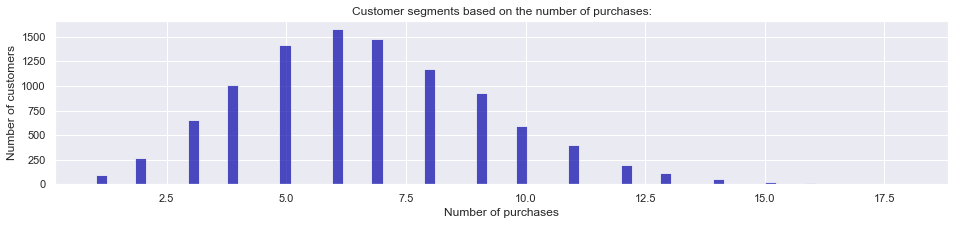

In [12]:
customer_purchases_count = purchases \
    .groupby(['customerid']).size() \
    .reset_index(name='number_of_purchases')

one_time_buyers = set(customer_purchases_count[customer_purchases_count['number_of_purchases'] == 1]['customerid'])
print('One-time Buyers: ', len(one_time_buyers))

plt.figure()
plt.title('Customer segments based on the number of purchases:')
plt.hist(
    x=customer_purchases_count['number_of_purchases'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('Number of purchases')
plt.ylabel('Number of customers')
plt.show()

**~1 % of our customers are one-time buyers**. This is quite a low figure. So far, it seems we will have a sufficient amount of information to represent relationships between items and customers.

To confirm this assumption, we need to check how many customers buy multiple items, ideally, across multiple categories. If someone buys repeatedly, but only one particular item, it will tell us nothing about relationships between items.

One-item Buyers:  92


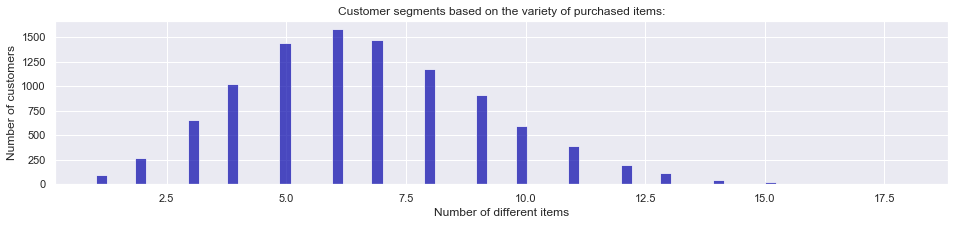

One-category Buyers:  175


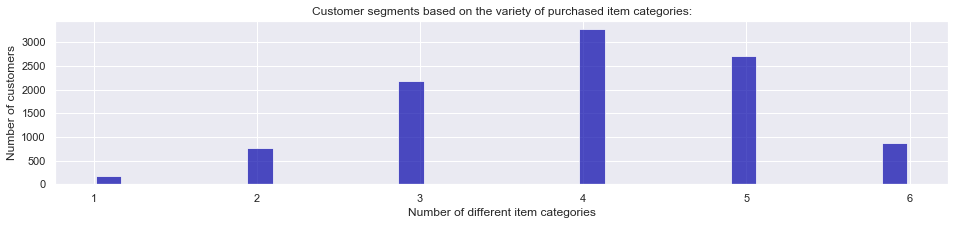

In [13]:
customer_purchases_items = purchases \
    .groupby(['customerid', 'itemid']).size() \
    .reset_index(name='counts') \
    .groupby(['customerid']).size() \
    .reset_index(name='item_variety_counts')

one_item_buyers = set(customer_purchases_items[customer_purchases_items['item_variety_counts'] == 1]['customerid'])
print('One-item Buyers: ', len(one_item_buyers))

plt.figure()
plt.title('Customer segments based on the variety of purchased items:')
plt.hist(
    x=customer_purchases_items['item_variety_counts'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('Number of different items')
plt.ylabel('Number of customers')
plt.show()


customer_purchases_categories = purchases \
    .groupby(['customerid', 'categoryid']).size() \
    .reset_index(name='counts') \
    .groupby(['customerid']).size() \
    .reset_index(name='category_variety_counts')

one_category_buyers = set(customer_purchases_categories[customer_purchases_categories['category_variety_counts'] == 1]['customerid'])
print('One-category Buyers: ', len(one_category_buyers))

plt.figure()
plt.title('Customer segments based on the variety of purchased item categories:')
plt.hist(
    x=customer_purchases_categories['category_variety_counts'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('Number of different item categories')
plt.ylabel('Number of customers')
plt.show()

We can see that there is the same number of one-time buyers and one-item buyers. This means that all the other customers purchased different items in their respective purchases. The distribution across items is almost identical with the distribution across the number of purchases. This suggests that **our customers almost never buy the same item twice**.

Similarly, for item categories. **Almost no customers buy from the same category twice**. This is good news for us because it means we will be probably able to capture some relationships between the items and customers.

The last thing we will examine is **distribution across customer features**. We need to see how much data we have for different user segments. This information will tell us whether we can use the same model for all customers. If some customer segments are underrepresented, it may be better not to use the model for them. In this template, we will analyze only one customer feature - `sexid`. The analysis of the remaining values is up to you :)

sexid  number_of_purchases_overall
0      0                         4961
1      1                         5029

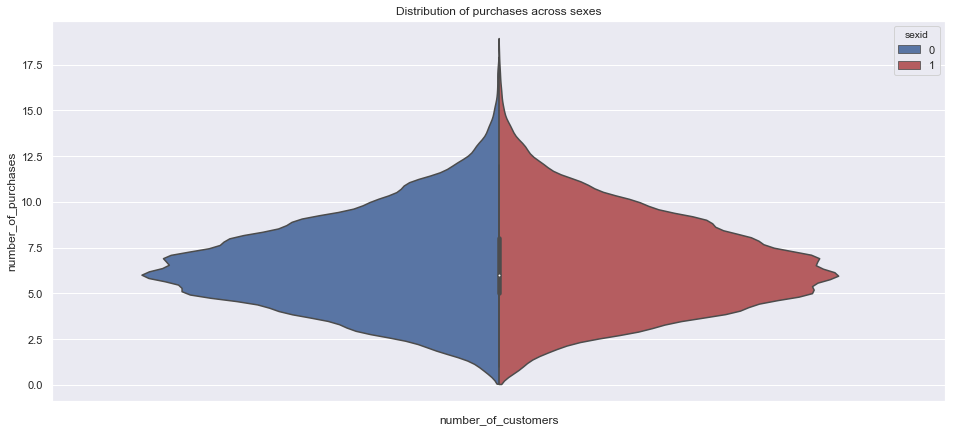

In [14]:
customer_purchases_sex = purchases \
    .groupby(['customerid', 'sexid']).size() \
    .reset_index(name='number_of_purchases')

customer_purchases_sex_overall = customer_purchases_sex \
    .groupby(['sexid']).size() \
    .reset_index(name='number_of_purchases_overall')

customer_purchases_sex['number_of_customers'] = ""

sns.set(rc={'figure.figsize':(16, 7)})
sns.violinplot(
    x="number_of_customers",
    y="number_of_purchases",
    hue="sexid",
    data=customer_purchases_sex,
    palette=['b','r'],
    split=True
).set_title('Distribution of purchases across sexes')

customer_purchases_sex_overall

The data is evenly distributed across both sexes which is good. If the opposite were true, we would need to think about how to create a proper dataset for training and testing in respect of `sexid`.

### 1.4 Data exploration: item segments

Now we do the same for items. Let's explore the purchase counts first. **It may be better not to use machine learning for items with very low purchases count and use predefined rules instead**.

Maximum number of transactions for one item: 438


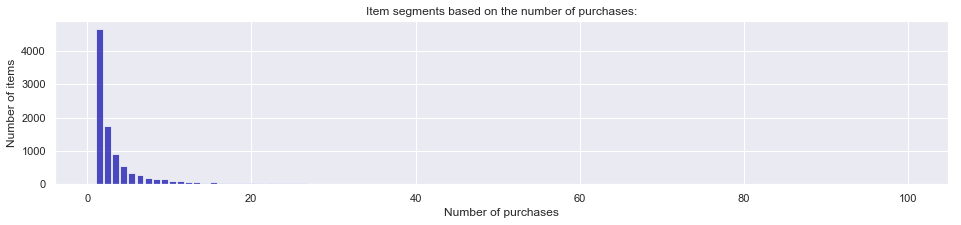

Purchases distribution across categories:


categoryid  number_of_purchases
0           0                11150
1           1                11572
2           2                10895
3           3                10532
4           4                11096
5           5                11413

In [15]:
item_purchases_count = purchases \
    .groupby(['itemid']).size() \
    .reset_index(name='counts')

print('Maximum number of transactions for one item:', max(item_purchases_count['counts']))

sns.set(rc={'figure.figsize':(16, 3)})
plt.figure()
plt.title('Item segments based on the number of purchases:')
plt.hist(
    x=item_purchases_count[item_purchases_count['counts'] <= 100]['counts'],
    bins= 100,
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('Number of purchases')
plt.ylabel('Number of items')
plt.show()

category_purchases_count = purchases \
    .groupby(['categoryid']).size() \
    .reset_index(name='number_of_purchases')

print('Purchases distribution across categories:')
category_purchases_count

**Most of the items were purchased fewer than five times.** This is not very good. We should decide whether a sufficient model could be developed or not.

On the other hand, **we have few items with hundreds of purchases**. In this case, we should discuss whether these outliers are relevant for our modeling. The reason for that is that some items or item categories could represent accessory products which are ordered almost automatically with every purchase. It may be unnecessary to promote them further.

On the other hand, **purchases distribution across categories is quite even**.

And that's it! It seems there aren't any big obstacles in modeling. The only problem is that the vast amount of items is bought only once. We need to bear this in mind when doing the modeling. It may be better to focus on similarities between categories.

We are done with the initial data exploration. **Now we are ready for experimenting!**

## 2 Experiments and AI prototyping

As mentioned earlier, data exploration is about figuring out what kind of model could be developed. In general, it all depends on the amount of data and its distribution across segments and features (the **search space**). A simple model based on good features always beats a complex model based on poor features.

In this notebook, we will experiment with two different approaches:
    - hard coded rules
    - machine learning

### 2.1 Hard coded rules

In case we are not sure about the data quantity and quality, an **expert system (or hard coded rules)** is probably the best option we have.

Expert systems have been around for nearly 50 years. We can think of them as hard coded decision trees. Tree rules are based on expert knowledge and statistical evidence. In e-commerce, we can use such rules as:
    - if the weather is cold, recommend a coat
    - if a customer already bought something in the past, recommend something which he/she has not yet bought
    - if a customer browses the "shoes" category, recommend something from the "belts" category

In our example category names and product names are not available explicitly. Instead, we have categoryids and productids. The same applies for customer sex and item color. That's why we rely on a statistical analysis.

In this template we will analyze connections between customer `sexid`, item `colorid` and `categoryid`. The analysis of the remaining values is up to you :)

#### Hard coded rules - item color
The only customer-related feature we have is a `sexid`. Let's see the relationship of this feature with the item color.

In this notebook we will perform two types of examinations:
    - how does sexid relate to colorid?
    - how do colorids relate between themselves?

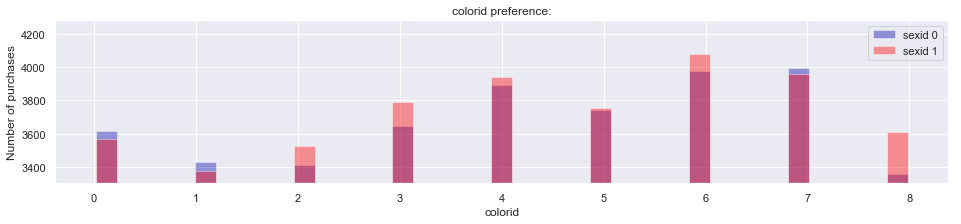

In [16]:
def preferencePlotSex(column_name, plot_setup=None):
    plt.figure()
    plt.title('%s preference:' % column_name)
    plt.hist(
        x=purchases[purchases['sexid'] == 0][column_name],
        bins='auto',
        color='#0504aa',
        alpha=0.4,
        rwidth=0.85,
        label='sexid 0')
    plt.hist(
        x=purchases[purchases['sexid'] == 1][column_name],
        bins='auto',
        color='red',
        alpha=0.4,
        rwidth=0.85,
        label='sexid 1')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel(column_name)
    plt.ylabel('Number of purchases')
    if plot_setup:
        keys = set(list(plot_setup.keys()))
        if 'x_left' in keys: plt.xlim(left=plot_setup['x_left'])
        if 'x_right' in keys: plt.xlim(right=plot_setup['x_right'])
        if 'y_top' in keys: plt.ylim(top=plot_setup['y_top'])
        if 'y_bottom' in keys: plt.ylim(bottom=plot_setup['y_bottom'])
    plt.show()

sns.set(rc={'figure.figsize':(16, 3)})
plot_setup_color = {
    'y_bottom': 3300
}
preferencePlotSex('colorid', plot_setup_color)

In general, there isn't a strong relationship between the item color and `sexid`. We can see that the `colorid ` 8 is slightly more preferred among the `sexid` 1 (~3350 vs ~3600 purchases).

Now, let's see how colors relate between themselves. We will get this information by looking at the number of customers that bought items from multiple categories. This kind of relationship could be nicely represented via a matrix. Let's define a function which will compute it:

In [17]:
def computeMatrix(data_frame, column_name):
    """
    Returns a symmetric matrix for the given column
    which represents how many customers
    who bought an item of the given column value
    also bought an item of the other column values.
    
    Parameters
    -----------
    data_frame
        Pandas data frame with transaction data
    column_name
        The name of the column for which we are computing the matric
    """

    # prepare variables
    # sort the column_values list for plotting purposes (order of the labels)
    column_values = list(set(data_frame[column_name]))
    column_values.sort()
    column_values_count = len(column_values)
    matrix = np.zeros(shape=(column_values_count, column_values_count))

    # compute the matrix
    for i in range(column_values_count):
        # select the value to compute the stats for
        value = column_values[i]
        # select customers who purchased at least one item with the given value
        customerid_selection = set(data_frame[data_frame[column_name] == value]['customerid'])
        # select purchases from the selected customers
        data_frame_filtered = data_frame[
            purchases['customerid'].apply(lambda customerid: customerid in customerid_selection) == True
        ]
        # group the final dataframe to get the number of customers
        # who bought an item of the value 'i' and also of the value 'j'
        purchases_count = data_frame_filtered \
            .groupby(['customerid', column_name]).size() \
            .reset_index(name='number_of_purchases') \
            .groupby([column_name]).size() \
            .reset_index(name='number_of_customers')
        available_values = set(purchases_count[column_name])
        # fill the matrix
        matrix[i, i] = 0 # set the diagonal to 0
        for j in range(column_values_count):
            # perform the operation only for the indices above the diagonal of the symmetric matrix
            if (i == j) | (j < i):
                continue
            else:
                # check whether any item with the value 'j'
                # was purchased by any customer who also
                # purchased an item with the value 'i'
                if j in available_values:
                    customer_count = list(purchases_count[purchases_count[column_name] == j]['number_of_customers'])[0]
                    matrix[i, j] = customer_count
                    # fill the other half of the matrix
                    matrix[j, i] = customer_count
                else:
                    matrix[i, j] = 0
                    matrix[j, i] = 0
    
    return matrix

Now let's define the functions which will visualize the matrix. We will use ones that come with the matplotlib documentation ( https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html ):

In [18]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

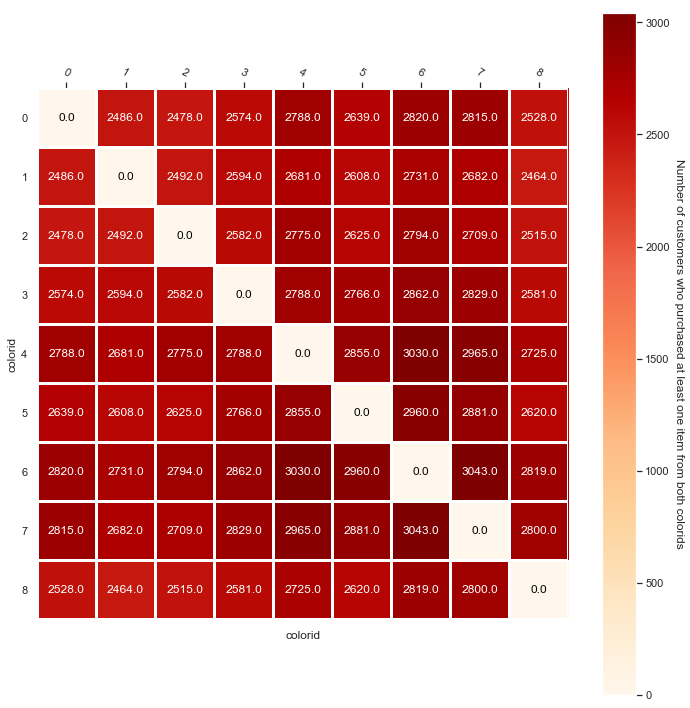

In [19]:
color_X_color_matrix = computeMatrix(purchases, 'colorid')
color_labels = list(set(purchases['colorid']))
color_labels.sort()

sns.set(rc={'figure.figsize':(10, 10)})
sns.set_style("dark")

fig, ax = plt.subplots()

im, cbar = heatmap(color_X_color_matrix, color_labels, color_labels, ax=ax,
                   cmap="OrRd", cbarlabel="Number of customers who purchased at least one item from both colorids")
texts = annotate_heatmap(im, valfmt="{x}")
plt.xlabel('colorid')
plt.ylabel('colorid')

fig.tight_layout()
plt.show()

As we can see, there aren't any strong relationships. We have two values above 3000: 3043 (`colorid` 6, `colorid` 7) and 3030 (`colorid` 4, `colorid` 6).

We can summarize the insights into a few simple rules:
    - if customer.sexid = 1 then promote item with colorid 8
    - if item.colorid = 6 then promote item with colorid 7 or colorid 4
    - if item.colorid = 7 then promote item with colorid 6
    - if item.colorid = 4 then promote item with colorid 6

Now let's have a look at the item category.

#### Hard coded rules - item category

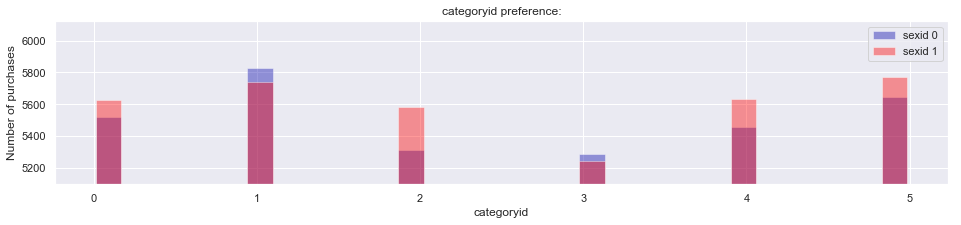

In [20]:
sns.set(rc={'figure.figsize':(16, 3)})
plot_setup_category = {
    'y_bottom': 5100
}
preferencePlotSex('categoryid', plot_setup_category)

No strong relationships here. Nevertheless, category 2 is preferred slightly more among customers with sexid 1.

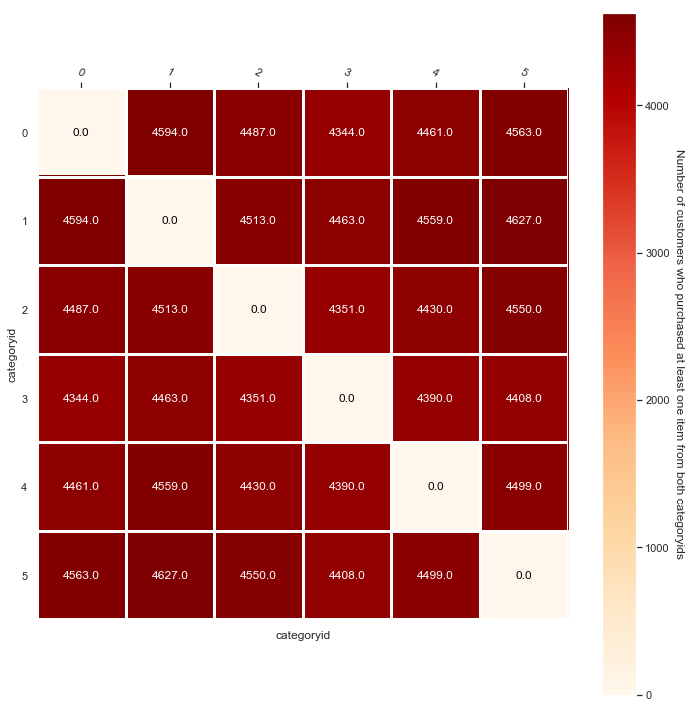

In [21]:
category_X_category_matrix = computeMatrix(purchases, 'categoryid')
category_labels = list(set(purchases['categoryid']))
category_labels.sort()

sns.set(rc={'figure.figsize':(10, 10)})
sns.set_style("dark")

fig, ax = plt.subplots()

im, cbar = heatmap(category_X_category_matrix, category_labels, category_labels, ax=ax,
                   cmap="OrRd", cbarlabel="Number of customers who purchased at least one item from both categoryids")
texts = annotate_heatmap(im, valfmt="{x}")
plt.xlabel('categoryid')
plt.ylabel('categoryid')

fig.tight_layout()
plt.show()

No strong relationships among categoryids. The highest values are: 4627 (`categoryid` 1, `categoryid` 5) and 4594 (`categoryid` 0, `colorid` 1).

Let's summarize our insights into some other simple rules:
    - if customer.sexid = 1 then promote item with categoryid 2
    - if item.categoryid = 0 then promote item with categoryid 1
    - if item.categoryid = 1 then promote item with categoryid 0 or categoryid 5
    - if item.categoryid = 5 then promote item with categoryid 1

#### Hard coded rules - building the model

Now, when we have formulated some rules, we can proceed to construct a simple recommendation model. Real recommendation engines are, of course, much more complex.

Let's define a function which will recommend a set of items based on the item which is being viewed by the customer:

In [22]:
import random

def getCoefficient(customer_sex, item_color, item_category,
           item_color_selected, item_category_selected,
           promotion_rate=0.05):
    """
    Returns promotion coefficient
    based on the hard coded rules.
    
    Parameters
    -----------
    customer_sex
        sexid of the customer
    item_color
        colorid of the item
        for which we are making recommendation
    item_category
        categoryid of the item
        for which we are making recommendation
    item_color_selected
        colorid of the item
        we are considering for recommendation
    item_category_selected
        categoryid of the item
        we are considering for recommendation
    promotion_rate
        A float number which represents
        the weight of the rules when adjusting
        the promotion coefficient.
        Default value is 0.05
        (the probability of selection will be
        increased by 5 % if the rule is applied).
    """
    coefficient = 1
    promotion = 1 + promotion_rate
    
    if (customer_sex == 1) and (item_color_selected == 8):
        coefficient *= promotion
        
    if (item_color == 4) and (item_color_selected == 6):
        coefficient *= promotion
        
    if (item_color == 6) and (item_color_selected == 4 or item_color_selected == 7):
        coefficient = coefficient*promotion
        
    if (item_color == 7) and (item_color_selected == 6):
        coefficient *= promotion
        
    if (customer_sex == 1) and (item_category_selected == 2):
        coefficient *= promotion
        
    if (item_category == 0) and (item_category_selected == 1):
        coefficient *= promotion
        
    if (item_category == 1) and (item_category_selected == 0 or item_category_selected == 5):
        coefficient *= promotion
        
    if (item_category == 5) and (item_category_selected == 1):
        coefficient *= promotion
        
    return coefficient

def recommendItemsRules(item_data_frame, customer_data_frame,
                   item_id_selected, customerid, n):
    """
    Returns a list of items
    which are suitable for recommendation
    using the hard coded rules.
    
    Parameters
    -----------
    item_data_frame
        Pandas data frame with item data
    customer_data_frame
        Pandas dataframe with customer data
    item_id_selected
        itemid of the item
        for which we are making recommendation
    customerid
        customerid of the customer
        for who we are making recommendation
    n
        number of items to recommend
    """
    # assign a random score to each item
    item_data_frame['score'] = item_data_frame['itemid'].apply(lambda x: random.random())

    # get the customer sexid
    customer = customer_data_frame[customer_data_frame['customerid'] == customerid]
    customer_sex = list(customer['sexid'])[0]
    
    # get the colorid and categoryid of the item
    item_row_selected = item_data_frame[item_data_frame['itemid'] == item_id_selected]
    item_color_selected = list(item_row_selected['colorid'])[0]
    item_category_selected = list(item_row_selected['categoryid'])[0]
    
    # promote items based on our rules
    item_data_frame['score'] = item_data_frame.apply(
        lambda item: item['score']*getCoefficient(
            customer_sex,
            item_color_selected,
            item_category_selected,
            item['colorid'],
            item['categoryid']),
        axis=1
    )
    
    # nullify the score of the current item to prevent its recommendation
    item_data_frame.loc[item_data_frame['itemid'] == item_id_selected, 'score'] = 0
    
    # pick items based on their score
    sorted_items = item_data_frame[['itemid', 'score']].sort_values(by ='score', ascending=False)
    # check that the n is not larger than the number of items
    number_to_recommend = min(n, sorted_items.shape[0])
    
    # clean up
    item_data_frame.drop(columns=['score'], inplace=True)
    
    return list(sorted_items['itemid'][:number_to_recommend])
    

Let's see how this works!

First, we will create testing data. In this case, `customerid`-`itemid` pairs which will represent that a particular item is being viewed by a particular customer:

In [23]:
testing_data_count = 5
dataset_test = pd.DataFrame(
    {
        'customerid': [
            customers.loc[random.choice(customers.index)]['customerid']
            for i in range(testing_data_count)
        ],
        'itemid': [
            items.loc[random.choice(items.index)]['itemid']
            for i in range(testing_data_count)
        ]
    }
)
print('First five rows of our testing data:')
dataset_test[:5]

First five rows of our testing data:


customerid  itemid
0       14329   24847
1       16910   48247
2       16894   48912
3       15381   37359
4       15345   37659

Once we have the testing data, we can call our recommender:

In [24]:
items_to_recommend = 3
dataset_test['recommendation_rules'] = dataset_test.apply(
    lambda purchase: recommendItemsRules(
        items,
        customers,
        purchase['itemid'],
        purchase['customerid'],
        items_to_recommend
    ), axis=1
)
print('First five rows of our testing data with recommendations:')
dataset_test[:5]

First five rows of our testing data with recommendations:


customerid  itemid   recommendation_rules
0       14329   24847  [18226, 47307, 18257]
1       16910   48247  [46242, 46981, 31654]
2       16894   48912  [31491, 48495, 16291]
3       15381   37359  [26544, 25417, 29247]
4       15345   37659  [31699, 31895, 45045]

### 2.2 Machine Learning

In general, there are two ways of using the AI for recommendations:
    1. relevance between items based on the transaction history
    2. similarity between items (or customers) based on the text (description, tags) or images (item pictures)
    
Option 2. could be solved as a separate problem and there are plenty of on-line materials how to approach it (image recognition, natural language processing). That's why we will only cover option 1. in this notebook.

#### Machine Learning - similarity matrix

A common way to create personalized content in on-line and e-commerce businesses is associative modeling. In the previous part we used a matrix to represent how many customers purchased items of various colors or categories. The same approach could be used for representing relationships between items or categories.

A similarity matrix is a square symmetric matrix where index `[i, j]` represents the similarity between items `i` and `j`. At the start, the matrix is filled with zeros, ones or some other value. The matrix is usually updated with every purchase. It can be updated on a daily or weekly basis as well.

Our ML recommendation engine will consist of two functions - `updateMatrix()` and `recommendItemsMatrix()`. `updateMatrix()` will update the matrix after the purchase. `recommendItemsMatrix()` will be similar to the `recommendItemsRules()` function used in the previous example. We will also need some data structures to represent the model. Let's create two matrices: `item_X_item` to represent similarities between items and `customer_X_item` to represent which customers bought which items.

In [25]:
itemids = list(set(items['itemid']))
item_X_item = np.full((items.shape[0], items.shape[0]), 0.5)
np.fill_diagonal(item_X_item, 0)

customer_X_item = np.zeros(shape=(customers.shape[0], items.shape[0]))

In [26]:
def updateRow(similarity_matrix, customer_X_item_matrix,
              index_customer, index_item,
              promotion_rate=0.005):
    """
    Updates particular fields in similarity matrix
    with new transaction.
    
    Parameters
    ----------
    similarity_matrix
        A symetric numpy matrix where index [i, j]
        represents the similarity between the item `i` and item `j`.
    customer_X_item_matrix
        A numpy matrix where index [i, j] is 1
        if the customer `i` purchased the item `j` in the past;
        0 if not
    index_customer
        index of the customerid in the customer_X_item_matrix
    index_item
        index of the itemid in the  similarity_matrix
    promotion_rate
        A float value which is used when increasing indices
        of the item_X_item_matrix during the update.
        We can think of it as a learning speed.
        Default value is 0.005.
    """
    # get fields to update
    customer_X_item_matrix[index_customer, index_item] = 1
    customer_stats = customer_X_item_matrix[index_customer,:]
    items_to_update = np.where(customer_stats == 1)
        
    # update the first half of the matrix
    similarity_matrix[items_to_update, index_item] += promotion_rate
    # update the second half of the matrix
    similarity_matrix[index_item, items_to_update] += promotion_rate
    
def normalizeMatrix(similarity_matrix, normalization_threshold=5):
    """
    Normalizes the similarity_matrix
    into the 0-1 interval.
    
    Parameters
    ----------
    similarity_matrix
        A symetric numpy matrix where index [i, j]
        represents the similarity between the item `i` and item `j`.
    normalization_threshold
        A threshold value.
        If any index of the item_X_item_matrix exceeds
        this value, the matrix is normalized into the 0-1 interval.
        Default value is 5.
    """
    # normalize data into 0-1 range if the maximum value
    # in the similarity matrix exceeds the normalization_threshold
    maximum = similarity_matrix.max()
    if maximum > normalization_threshold:
        # before computing the matrix minimum, we create
        # a mask to ignore the zero diagonal
        diagonal_mask = np.ones(similarity_matrix.shape, dtype=bool)
        np.fill_diagonal(diagonal_mask, 0)            
        minimum = similarity_matrix[diagonal_mask].min()
        if minimum != maximum:
            similarity_matrix -= minimum
            similarity_matrix /= (maximum - minimum)

def updateMatrix(itemid_list, customers_data_frame,
                 similarity_matrix, customer_X_item_matrix,
                 item_id_selected, customerid,
                 promotion_rate=0.005, normalization_threshold=5):
    """
    Updates an existing similarity matrix
    with new transaction.
    
    Parameters
    ----------
    itemid_list
        A list of itemids
    customer_data_frame
        Pandas dataframe with customer data
    similarity_matrix
        A symetric numpy matrix where index [i, j]
        represents the similarity between the item `i` and item `j`.
    customer_X_item_matrix
        A numpy matrix where index [i, j] is 1
        if the customer `i` purchased the item `j` in the past;
        0 if not
    item_id_selected
        itemid of the item
        for which we are editing values
    customerid
        customerid of the customer
        for who we are editing values
    promotion_rate
        A float value which is used when increasing indices
        of the item_X_item_matrix during the update.
        We can think of it as a learning speed.
        Default value is 0.005.
    normalization_threshold
        A threshold value.
        If any index of the item_X_item_matrix exceeds
        this value, the matrix is normalized into the 0-1 interval.
        Default value is 5.
    """
    # get itemid and customerid indices
    index_item = itemid_list.index(item_id_selected)
    index_customer = np.where(customers_data_frame['customerid'] == customerid)[0][0]
    
    # look whether or not the customer bought the item in the past;
    # if not, proceed
    if customer_X_item_matrix[index_customer, index_item] == 0:
        
        # update the statistics for the customer-item relationship
        updateRow(
            similarity_matrix,
            customer_X_item_matrix,
            index_customer,
            index_item,
            promotion_rate
        )
    
        # normalize similarity_matrix
        normalizeMatrix(
            similarity_matrix,
            normalization_threshold
        )

        # reset the diagonal
        similarity_matrix[index_item, index_item] = 0

def recommendItemsMatrix(items_data_frame, customers_data_frame,
                         item_id_selected, item_X_item_matrix,
                         n):
    """
    Returns a list of items
    which are suitable for recommendation
    using a similarity matrix.
    
    Parameters
    -----------
    item_data_frame
        Pandas data frame with item data
    customer_data_frame
        Pandas dataframe with customer data
    item_id_selected
        itemid of the item
        for which we are making recommendation
    item_X_item_matrix
        A symetric numpy matrix where index [i, j]
        represents the similarity between the item `i` and item `j`.
    n
        number of items to recommend
    """
    # get itemid index in the item_X_item_matrix
    index_item = np.where(items_data_frame['itemid'] == item_id_selected)[0][0]
    
    # create a masked array to ignore the item for which
    # we are making recommendation
    item_stats = item_X_item_matrix[index_item,:]
    item_stats_mask = np.ma.array(item_stats, mask=False)
    item_stats_mask.mask[index_item] = True
    
    # check that the n is not larger than the number of items
    number_to_recommend = min(n, item_stats_mask.shape[0])
    
    # return itemids of the most similar items
    item_indices = np.argsort(item_stats_mask)[-number_to_recommend:]
    return list(items.loc[item_indices]['itemid'])

Now we can fill the matrix with the purchase data. We will use only first 10k rows in this template because the computation can be time consuming. The time complexity depends on the dimension of our matrices (item_X_item, customer_X_item).

In [27]:
d = datetime.now()
for index, purchase in purchases[:10000].iterrows():
    updateMatrix(
        itemids,
        customers,
        item_X_item,
        customer_X_item,
        purchase['itemid'],
        purchase['customerid']
    )
print('Computation time:', datetime.now() - d)

Computation time: 0:12:45.302444


Each row in the `item_X_item` matrix represents the similarity of the given item to all the other items. For example, the maximum similarity for the first item is:

In [28]:
max_similarity_item_0 = max(item_X_item[0,:])
max_similarity_item_0

0.5

And the index of the corresponding most similar item is:

In [29]:
corresponding_item_index = np.where(item_X_item[0,:] == max_similarity_item_0)[0][0]
corresponding_item_index

1

Which leads us to the `itemid` of the most similar item:

In [30]:
items.loc[corresponding_item_index]['itemid']

32775

Now we are ready to compute recommendations. We can use the same `dataset_test` we used for the hard coded rules method. New recommendations will be saved into the `recommendation_matrix` column so we can compare how they differ from the suggestion of the previous model (`recommendation_rules` column).

In [31]:
dataset_test['recommendation_matrix'] = dataset_test.apply(
    lambda purchase: recommendItemsMatrix(
        items,
        customers,
        purchase['itemid'],
        item_X_item,
        items_to_recommend
    ), axis=1
)
print('First five rows of our testing data with recommendations:')
dataset_test[:5]

First five rows of our testing data with recommendations:


customerid  itemid   recommendation_rules  recommendation_matrix
0       14329   24847  [18226, 47307, 18257]  [43145, 32767, 24847]
1       16910   48247  [46242, 46981, 31654]  [43220, 32767, 48247]
2       16894   48912  [31491, 48495, 16291]  [43074, 32767, 48912]
3       15381   37359  [26544, 25417, 29247]  [43164, 32767, 37359]
4       15345   37659  [31699, 31895, 45045]  [43164, 32767, 37659]

The whole learning progress of the matrix `item_X_item` could be visualized, but the matrix is too big to do this inside this notebook. Instead, we will demonstrate the learning process using item categories. We will create a new matrices `category_X_category` and `customer_X_category` which will use `categoryid` instead of `itemid`:

In [32]:
categories = list(set(items['categoryid']))
categories_count = len(categories)

category_X_category = np.full((categories_count, categories_count), 0.5)
np.fill_diagonal(category_X_category, 0)

customer_X_category = np.zeros(shape=(customers.shape[0], categories_count))

Let's split the purchases dataset into three parts and see, how the learning progresses over time:

In [33]:
purchases_part_1 = purchases[:20000]
purchases_part_2 = purchases[20000:40000]
purchases_part_3 = purchases[40000:]

Now let's see how the learning progresses:

Similarity matrix before learning:


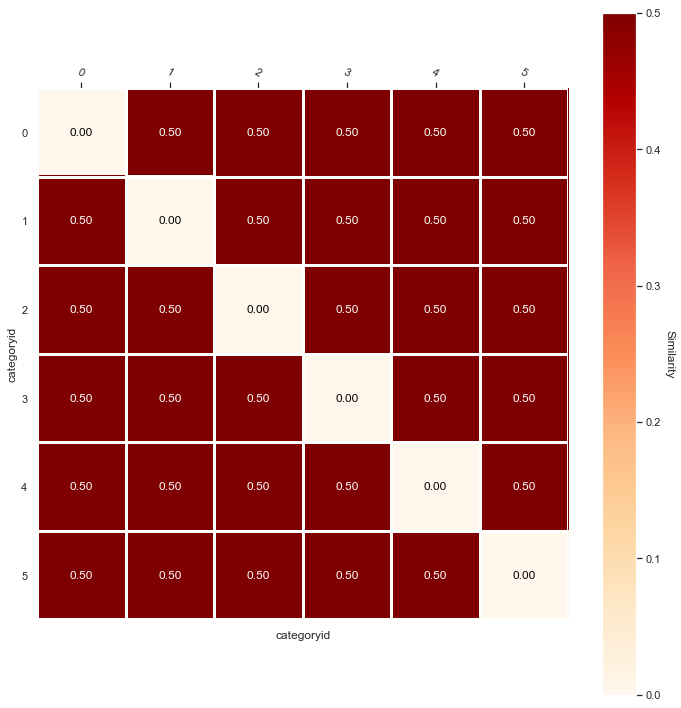

Similarity matrix after adding the first part:


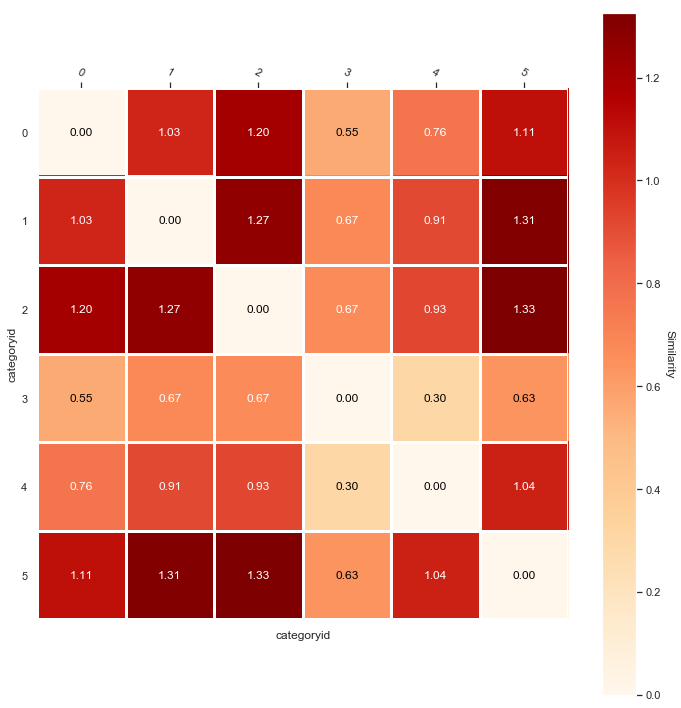

Similarity matrix after adding the second part:


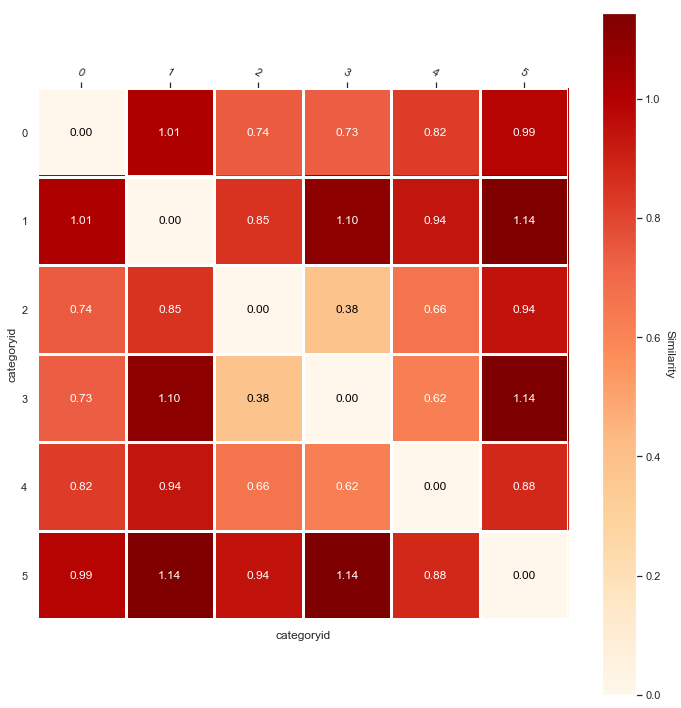

Similarity matrix after adding the last part:


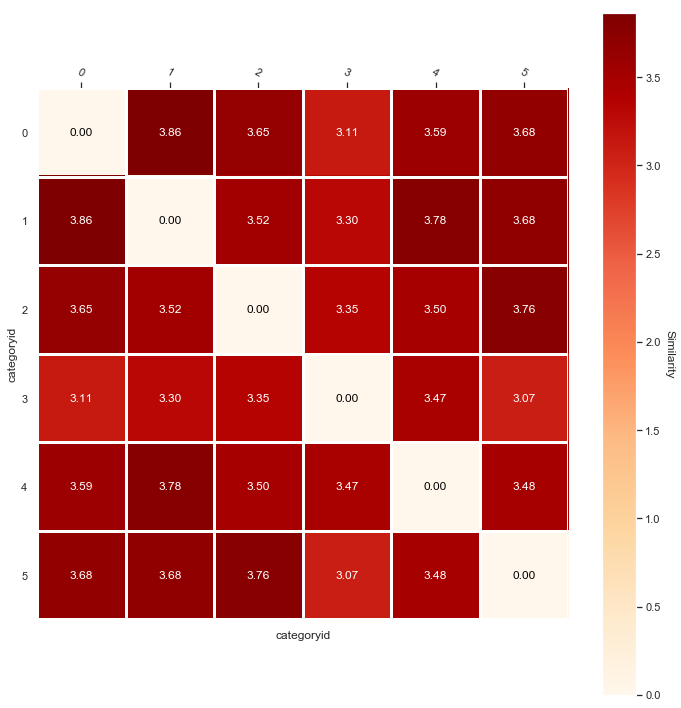

In [34]:
def showMatrix():
    sns.set(rc={'figure.figsize':(10, 10)})
    sns.set_style("dark")
    fig, ax = plt.subplots()
    im, cbar = heatmap(category_X_category, categories, categories, ax=ax,
                       cmap="OrRd", cbarlabel="Similarity")
    texts = annotate_heatmap(im, valfmt="{x:.2f}")
    plt.xlabel('categoryid')
    plt.ylabel('categoryid')
    fig.tight_layout()
    plt.show()

print('Similarity matrix before learning:')
showMatrix()

print('Similarity matrix after adding the first part:')
for index, purchase in purchases_part_1.iterrows():
    updateMatrix(
        categories,
        customers,
        category_X_category,
        customer_X_category,
        purchase['categoryid'],
        purchase['customerid']
    )
showMatrix()

print('Similarity matrix after adding the second part:')
for index, purchase in purchases_part_2.iterrows():
    updateMatrix(
        categories,
        customers,
        category_X_category,
        customer_X_category,
        purchase['categoryid'],
        purchase['customerid']
    )
showMatrix()

print('Similarity matrix after adding the last part:')
for index, purchase in purchases_part_3.iterrows():
    updateMatrix(
        categories,
        customers,
        category_X_category,
        customer_X_category,
        purchase['categoryid'],
        purchase['customerid']
    )
showMatrix()

The learning speed is determined by the `promotion_rate` argument of the `updateMatrixCategory()` function. The important part of every AI project is to determine how fast the learning process should be. Another important task is to decide which method will be used to normalize the model. In our scenario, we normalize the model into 0-1 interval via the `normalizeMatrix()` function when the maximum value in the similarity matrix exceeds the `normalization_threshold`. We can think of it as a gradual forgetting of the previously learned relationships. Therefore, the similarity value for categories 0 and 2 after the second part of the learning process is 0.74, although after the first part of the learning process it was 1.2.

### 2.3 Experiments and AI prototyping wrap-up

There are multiple ways to create a content personalization model. In this notebook we have introduced you only to the two most common: hard coded rules and machine learning via a similarity matrix. Each approach has its pros and cons:

**hard coded rules**
- pros:
    - understandability
    - computation time
    - data requirements
- cons:
    - preparation time (all rules need to be created manually)
    - rigidity (the model does not adapt to changing conditions)
    - maintenance (must be adjusted manually)
    
**machine learning with similarity matrix**
- pros:
    - almost no maintenance needed because of the adaptability
    - performance increases with the amount of data
- cons:
    - computation time
    - data requirements
    - slightly worse understandability
    
In practice, we can easily combine both approaches to get the best of both approaches.

## What to do next

We hope this notebook has helped you. Do you have any ideas on how to improve it? Let us know and share it with your peers!

Are you struggling with AI? Contact us! You can reach us via our website
- https://www.pbi.ai/.

or social media
- facebook https://www.facebook.com/pbiai/
- LinkedIn https://www.linkedin.com/company/18178189/
- Twitter https://twitter.com/pbi_ai

In [35]:
end_time = datetime.now()
print('end_time:', end_time)
print('elapsed_time:', end_time - start_time)

end_time: 2019-11-13 17:53:17.094401
elapsed_time: 0:13:16.867967
